In [32]:

!pip install ucimlrepo tensorflow scikit-learn pandas numpy matplotlib seaborn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras
from tensorflow.keras import layers
from ucimlrepo import fetch_ucirepo

dataset = fetch_ucirepo(id=374)
X = dataset.data.features
y = dataset.data.targets

y = y["Appliances"]

print("Размер данных:", X.shape, y.shape)
X.head()


Размер данных: (19735, 28) (19735,)


,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-1117:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-1117:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-1117:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-1117:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,2016-01-1117:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [33]:

X = X.drop(columns=["date"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Размер обучающей выборки:", X_train_scaled.shape)
print("Размер тестовой выборки:", X_test_scaled.shape)


Размер обучающей выборки: (15788, 27)
Размер тестовой выборки: (3947, 27)


In [34]:

def build_base_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)  # регрессия
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

base_model = build_base_model(X_train_scaled.shape[1])

history_base = base_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

# Предсказание и оценка
y_pred_base = base_model.predict(X_test_scaled)
mape_base = mean_absolute_percentage_error(y_test, y_pred_base)

print(f"MAPE без предобучения: {mape_base:.4f}")


Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16381.9521 - val_loss: 9396.6357
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9963.8838 - val_loss: 8741.6426
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9165.9355 - val_loss: 8565.3906
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8840.6875 - val_loss: 8343.1279
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8561.3730 - val_loss: 8272.8203
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8882.5449 - val_loss: 8218.3535
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8252.9746 - val_loss: 8213.8926
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7441.2642 - val_loss: 7972.6929
Epoch 9/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7923.0977 - val_loss: 7927.9932
Epoch 10/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8203.1543 - val_loss: 7842.8662
Epoch 11/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7765.4614 - val_l

In [35]:

input_dim = X_train_scaled.shape[1]
encoding_dim = 16  # размер скрытого кода

# Архитектура автоэнкодера
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение автоэнкодера
history_ae = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

# Извлечение энкодера
encoder = keras.Model(inputs=input_layer, outputs=encoded)


Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4694 - val_loss: 0.0829
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0685 - val_loss: 0.0485
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0441 - val_loss: 0.0371
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.0332
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315 - val_loss: 0.0299
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0290 - val_loss: 0.0280
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - val_loss: 0.0265
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0251 - val_loss: 0.0245
Epoch 9/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0242 - val_loss: 0.0235
Epoch 10/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0229 - val_loss: 0.0225
Epoch 11/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0221 - val_loss: 0.0224
Epoch 12/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [36]:

encoded_train = encoder.predict(X_train_scaled)
encoded_test = encoder.predict(X_test_scaled)

def build_pretrained_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

pretrained_model = build_pretrained_model(encoded_train.shape[1])

history_pre = pretrained_model.fit(
    encoded_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

y_pred_pre = pretrained_model.predict(encoded_test)
mape_pre = mean_absolute_percentage_error(y_test, y_pred_pre)

print(f"MAPE с предобучением (автоэнкодер): {mape_pre:.4f}")


494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18126.5039 - val_loss: 10074.3428
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10211.7461 - val_loss: 9978.8604
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9993.5137 - val_loss: 9866.7090
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10164.0342 - val_loss: 9755.3213
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10299.1299 - val_loss: 9639.0859
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9732.2529 - val_loss: 9554.2188
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10100.3145 - val_loss: 9498.6621
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9891.0205 - val_loss: 9470.7959
Epoch 9/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9589.5596 - val_loss: 9421.1777
Epoch 10/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9659.8125 - val_loss:

===== Appliances_Energy_Prediction Dataset =====
Without pretraining — MAPE: 0.4137
With pretraining — MAPE: 0.6642


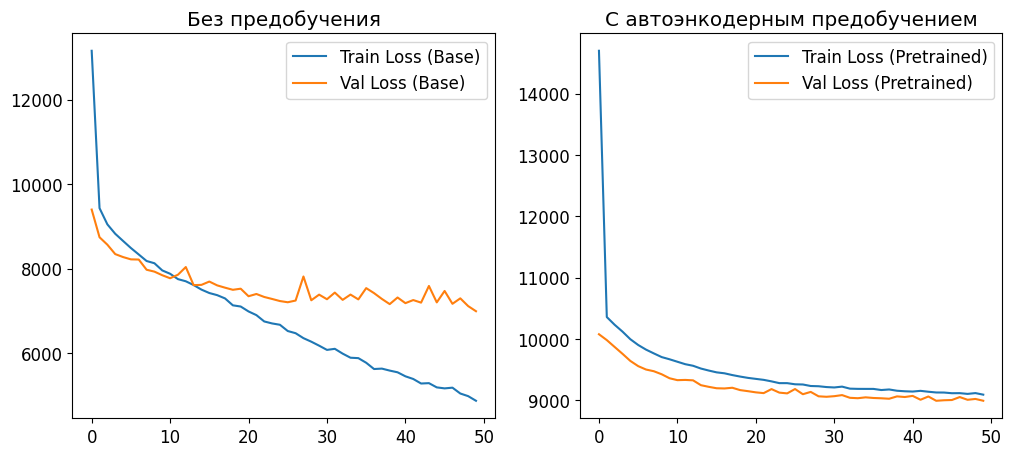

In [37]:

print("===== Appliances_Energy_Prediction Dataset =====")
print(f"Without pretraining — MAPE: {mape_base:.4f}")
print(f"With pretraining — MAPE: {mape_pre:.4f}")

# Графики обучения
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_base.history['loss'], label='Train Loss (Base)')
plt.plot(history_base.history['val_loss'], label='Val Loss (Base)')
plt.title('Без предобучения')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_pre.history['loss'], label='Train Loss (Pretrained)')
plt.plot(history_pre.history['val_loss'], label='Val Loss (Pretrained)')
plt.title('С автоэнкодерным предобучением')
plt.legend()

plt.show()
